In [1]:
import sys
sys.path.append('../src/')
from corpus import Corpus
from models import GTM
from simulations import generate_documents
from sklearn.feature_extraction.text import CountVectorizer

df_theta, df, topic_words, true_lambda, true_label_coeffs = generate_documents(
    num_docs=20000,
    num_topics=2,
    vocab_size=500,
    num_covs=2,
    num_languages=1,
    doc_topic_prior="logistic_normal",
    label_type="regression",
    random_seed=42
)

In [2]:
train = df.sample(frac=0.8,random_state=42)
test = df.drop(train.index).reset_index(drop=True)
train = train.reset_index(drop=True)

# ---- 1. Fit vectorizer on training set ----
vectorizer = CountVectorizer()  
vectorizer.fit(train["doc_clean_0"])

# ---- 2. Define modalities using this vectorizer ----
modalities = {
    "text": {
        "column": "doc_clean_0",
        "views": {
            "bow": {
                "type": "bow",
                "vectorizer": vectorizer
            }
        }
    }
}

# ---- 3. Create GTMCorpus datasets ----
train_dataset = Corpus(
    train,
    modalities=modalities,
    labels="~label-1",
    prevalence="~cov_1 + cov_2"
)

test_dataset = Corpus(
    test,
    modalities=modalities,  
    labels="~label-1",
    prevalence="~cov_1 + cov_2"
)

In [3]:
# Train the model

encoder_args = {
    "text_bow": {
        "hidden_dims": [128,64],
        "activation": "relu",
        "bias": True,
        "dropout": 0.2
    }
}

decoder_args = {
    "text_bow": {
        "hidden_dims": [64,128],
        "activation": "relu",
        "bias": True,
        "dropout": 0.2
    }
}

predictor_args = {
    "text_bow": {
        "hidden_dims": [],
        "activation": "relu",
        "bias": False,
        "dropout": 0.0
    }
}

tm = GTM(
    train_dataset, 
    test_dataset,
    ae_type="vae",
    update_prior=True,
    initialization=False,
    encoder_args=encoder_args,
    decoder_args=decoder_args,
    predictor_args=predictor_args,
    n_topics=2,
    doc_topic_prior='logistic_normal',
    predictor_type='regressor', 
    w_pred_loss=1,
    w_prior=1,
    patience=10,
    print_every_n_epochs=10,
    kl_annealing_start=0,
    kl_annealing_end=1000,
    kl_annealing_max_beta=1,
    num_epochs=100
)


Epoch  10	Mean Training Loss:5.2914476


Epoch  10	Mean Validation Loss:5.0544444


Stopping at Epoch 19. Reverting to Epoch 9


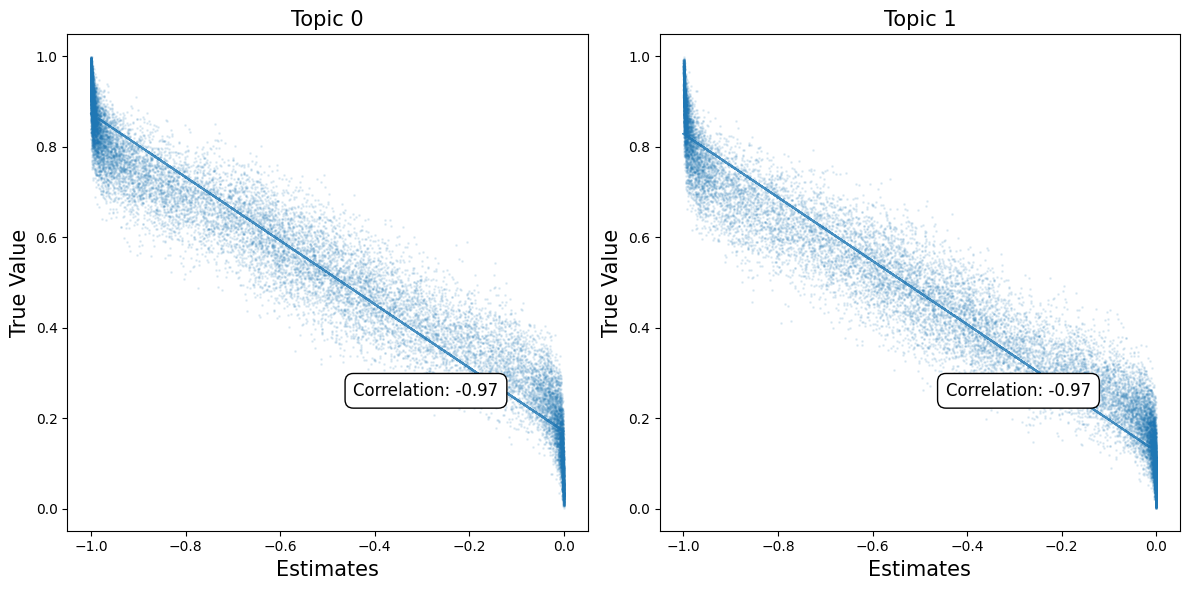

In [4]:
import matplotlib.pyplot as plt
import numpy as np

full_dataset = Corpus(
    df,
    modalities=modalities,
    labels="~label-1",
    prevalence="~cov_1 + cov_2"
)

estimated_doc_topics = -tm.get_doc_topic_distribution(full_dataset, num_samples=30)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i in range(2):  
    x = estimated_doc_topics[:, i]  
    y = df_theta['Topic{}'.format(i)]
    
    axs[i].scatter(x, y, s=1, alpha=0.1)
    
    coefficients = np.polyfit(x, y, 1)
    fit = np.poly1d(coefficients)
    axs[i].plot(x, fit(x), alpha=0.8)
    
    axs[i].set_xlabel('Estimates', fontsize=15)
    axs[i].set_ylabel('True Value', fontsize=15)
    axs[i].set_title(f'Topic {i}', fontsize=15)

    corr_coeff = np.corrcoef(x, y)[0, 1]
    axs[i].annotate(f'Correlation: {corr_coeff:.2f}', xy=(0.55, 0.3), xycoords='axes fraction',
                    fontsize=12, verticalalignment='top', horizontalalignment='left',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()

In [5]:
print("True label_coeffs:\n", true_label_coeffs)

print('Estimated weights:')
print(tm.predictor.neural_net["pred_0"].weight.detach().cpu())

True label_coeffs:
 [-0.30155392  0.16943492]
Estimated weights:
tensor([[-0.5240, -0.2026]])


In [6]:
tm.get_predictions(full_dataset, to_numpy=False)[0:10]

tensor([[ 0.0694],
        [-0.1640],
        [-0.1567],
        [-0.2435],
        [ 0.0707],
        [-0.2503],
        [-0.2506],
        [ 0.0706],
        [ 0.0548],
        [-0.1890]], device='cuda:0')

In [7]:
print(df['label'].iloc[0:10])

0    0.792817
1    0.142495
2   -0.512934
3   -0.501687
4    0.033063
5   -0.311968
6    0.288674
7   -0.436888
8    0.556063
9    0.369385
Name: label, dtype: float64


In [8]:
print("True label_coeffs:\n", true_lambda)

print('Estimated coefs:')
print(tm.prior.lambda_)

True label_coeffs:
 [[-0.40190159  0.29299588]
 [ 0.65314024 -0.61345784]
 [ 0.85615386 -0.06427552]]
Estimated coefs:
tensor([[ 0.0000,  2.4381],
        [ 0.0000, -3.4103],
        [ 0.0000, -2.5591]], device='cuda:0')
